#Project: Predicting Apple Stock Prices Using Pandas and Scikit-learn

Let’s say that we are trading stocks. We’re interested in making profitable stock trades with minimal risk. So when we buy a stock, we want to be fairly certain that the price will increase. We’ll buy stock when the market opens, and sell it when the market closes.

#Machine learning setup
To tell us when to trade, we want to train a machine learning model. This model needs to predict tomorrow’s closing price using data from today. If the model says that the price will increase, we’ll buy stock. If the model says that the price will go down, we won’t do anything.

We want to maximize our true positives – days when the model predicts that the price will go up, and it actually goes go up. Therefore, we’ll be using precision as our error metric for our model, which is true positives / (false positives + true positives). This will ensure that we minimize how much money we lose with false positives (days when we buy the stock, but the price actually goes down).

This means that we will have to accept a lot of false negatives – days when we predict that the price will go down, but it actually goes up. This is okay, since we’d rather minimize our potential losses than maximize our potential gains.

So our model will have low recall, but high precision. Here is more on precision and recall.

#Method
Before we get to the machine learning, we need to do a lot of work to acquire and clean up the data. Here are the steps we'll follow:
- Download historical stock prices from Yahoo finance
- Explore the data
- Setup the dataset to predict future prices using historical prices
- Test a machine learning model
- Setup a backtesting engine
- Improve the accuracy of the model

At the end, we'll document some potential future directions we can go in to improve the technique.

#Downloading the data
First, we'll download the data from Kaggle. We'll save the data after we download it, so we don't have to re-download it every time (this could cause our IP to get blocked).

We'll use data for a single stock (Apple) from when it started trading to the present.

In [ ]:
!pip install yfinance
import yfinance as yf
import os
import json
import pandas as pd

DATA_PATH = "aapl_data.json"

if os.path.exists(DATA_PATH):
    # Read from file if we've already downloaded the data.
    with open(DATA_PATH) as f:
        apple_hist = pd.read_json(DATA_PATH)
else:
    apple = yf.Ticker("AAPL")
    apple_hist = apple.history(period="max")

    # Save file to json in case we need it later.  This prevents us from having to re-download it every time.
    apple_hist.to_json(DATA_PATH)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 KB 1.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 KB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.2/128.2 KB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.2/112.2 KB 8.5 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.25.1
    Uninstalling requests-2.25.1:
      Successfully uninstalled requests-2.25.1
  Attempting uninstall: html5lib
    Found existing installation: html5lib 1.0.1
    Uninstalling html5lib-1.0.1:
      Successfully uninstalled html5lib-1.0.1
  Attempting uninstall: beautifulsoup4
    Found existing installation: beautifulsoup4 4.6.3
   

#Exploring the data
Next, we can take a look at googl to see the structure of the data. We’ll use the .head method on DataFrames to check the first 5 rows of the data.

As we can see below, we have one row of data for each day that Apple stock was traded up to March 24, 2022. Here are the columns:

- Open – the price the stock opened at
- High – the highest price during the day
- Low – the lowest price during the day
- Close – the closing price on the trading day
- Volume – how many shares were traded

The row index of the DataFrame is the date the stock was traded. Stock doesn’t trade every day (there is no trading on weekends and holidays), so some dates are missing.

In [ ]:
apple_hist.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,0.099874,0.100308,0.099874,0.099874,469033600,0.0,0.0
1980-12-15 00:00:00-05:00,0.095098,0.095098,0.094663,0.094663,175884800,0.0,0.0
1980-12-16 00:00:00-05:00,0.088149,0.088149,0.087715,0.087715,105728000,0.0,0.0
1980-12-17 00:00:00-05:00,0.089886,0.090320,0.089886,0.089886,86441600,0.0,0.0
1980-12-18 00:00:00-05:00,0.092492,0.092926,0.092492,0.092492,73449600,0.0,0.0


Next, we'll plot the data so we can see how the stock price has changed over time. This gives us another overview of the structure of the data.

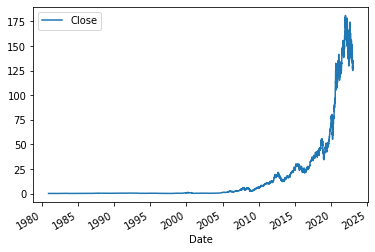

In [ ]:
apple_hist.plot(y="Close")

#Preparing the data
Now, let’s prepare the data so we can make predictions. As we mentioned in the introduction, we’ll be predicting if the price will go up or down tomorrow based on data from today.

First, we’ll identify a target that we’re trying to predict. Our target will be if the price will go up or down tomorrow. If the price went up, the target will be 1, and if it went down, the target will be 0.

Next, we’ll shift the data from previous days “forward” one day, so we can use it to predict the target price. This ensures that we don’t accidentally use data from the same day to make predictions! (a very common mistake)

Then, we’ll combine both so we have our training data.

#Setting up the target
First, we setup the target.

We do this by first copying the Close column to a new DataFrame called data and renaming it to actual_close. This ensures that we can continue to see the value that the stock actually closed at on each day. (we’ll be shifting things around later, so it’s important to preserve this).

Then, we setup our target by doing the following:
- Using the pandas rolling method across every 2 rows of the DataFrame. This will first look at (‘1986-03-13’, ‘1986-03-14’), then (‘1986-03-14’, ‘1986-03-17’), and so on across the DataFrame.
- We will compare the second row to the first row to see if it is greater. If it is, return 1, otherwise 0.
- We then just look at the Close column.

As you can see above, the Target column now indicates if the price went up or down on the given day. If Target is 1, the price went up. If Target is 0, the price went down.

This is what we want our machine learning model to predict!

In [ ]:
# Ensure we know the actual closing price
data = apple_hist[["Close"]]
data = data.rename(columns = {'Close':'Actual_Close'})

# Setup our target.  This identifies if the price went up or down
data["Target"] = apple_hist.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Close"]
data.head()

# If Target is 1, the price went up. If Target is 0, the price went down.

,Actual_Close,Target
Date,,
1980-12-12 00:00:00-05:00,0.099874,NaN
1980-12-15 00:00:00-05:00,0.094663,0.0
1980-12-16 00:00:00-05:00,0.087715,0.0
1980-12-17 00:00:00-05:00,0.089886,1.0
1980-12-18 00:00:00-05:00,0.092492,1.0


#Shifting data “forward”
Next, we’ll use the DataFrame shift method to move all rows “forward” one trading day.

As you can see, the prices for 1986-03-13 are now associated with 1986-03-14, and every other price is shifted up one row. This is to ensure that we’re predicting future prices using past data.

If we didn’t do this, we’d be using data from 03-14 to predict prices on 03-14. Instead, we need to use data from 03-13 to predict prices on 03-14. If we don’t do this, our model will look amazing when we’re testing it, but won’t work at all in the real world. In the real world, we don’t actually know the price tomorrow, so we can’t use it to make our predictions.

In [ ]:
apple_prev = apple_hist.copy()
apple_prev = apple_prev.shift(1)

apple_prev.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1980-12-12 00:00:00-05:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1980-12-15 00:00:00-05:00,0.099874,0.100308,0.099874,0.099874,469033600.0,0.0,0.0
1980-12-16 00:00:00-05:00,0.095098,0.095098,0.094663,0.094663,175884800.0,0.0,0.0
1980-12-17 00:00:00-05:00,0.088149,0.088149,0.087715,0.087715,105728000.0,0.0,0.0
1980-12-18 00:00:00-05:00,0.089886,0.090320,0.089886,0.089886,86441600.0,0.0,0.0


#Combining our data
Next, we need to combine our Target with the columns we want to use to predict the target. We’ll use this with the join method on DataFrames.

After we join our data, we see that we’ll be predicting the target using data from the previous day. The columns we’ll use to predict our target are ["Close", "Volume", "Open", "High", "Low"].

It’s good to be explicit with predictors to avoid accidentally using your target to predict itself. This will make your model look really good in training, but won’t work at all in the real world.

In [ ]:
# Create our training data
predictors = ["Close", "Volume", "Open", "High", "Low"]
data = data.join(apple_prev[predictors]).iloc[1:]

data.head()

,Actual_Close,Target,Close,Volume,Open,High,Low
Date,,,,,,,
1980-12-15 00:00:00-05:00,0.094663,0.0,0.099874,469033600.0,0.099874,0.100308,0.099874
1980-12-16 00:00:00-05:00,0.087715,0.0,0.094663,175884800.0,0.095098,0.095098,0.094663
1980-12-17 00:00:00-05:00,0.089886,1.0,0.087715,105728000.0,0.088149,0.088149,0.087715
1980-12-18 00:00:00-05:00,0.092492,1.0,0.089886,86441600.0,0.089886,0.090320,0.089886
1980-12-19 00:00:00-05:00,0.098137,1.0,0.092492,73449600.0,0.092492,0.092926,0.092492


#Creating a machine learning model
Next, we’ll create a machine learning model to see how accurately we can predict the stock price.

Because we’re dealing with time series data, we can’t just use cross-validation to create predictions for the whole dataset. This will cause leakage where data from the future will be used to predict past prices. This doesn’t match with the real world, and will make us think that our algorithm is much better than it actually is.

Instead, we’ll split the data sequentially. We’ll start off by predicting just the last 100 rows using the other rows.

We’ll use a random forest classifier to generate our predictions. This is a good “default” model for a lot of applications, because it can pick up nonlinear relationships in the data, and is somewhat robust to overfitting with the right parameters.

This is just to setup our model and ensure that things are working properly. To get an accurate error metric, we need to backtest across our entire price history. Once we setup the model, this will be our next step.

#Setting up the model
First, we’ll import a RandomForestClassifier from scikit-learn. We can install scikit-learn with pip install scikit-learn.

We’re using a classification algorithm because our target is binary (0/1). A 1 means the price went up, a 0 means it went down. If we had a different type of target (like the actual price), we might use a regression algorithm.

When we initialize the model, we pass in a few parameters:

- n_estimators – this is the number of individual decision trees that the algorithm should create. A random forest is an ensemble of decision trees that is more robust to overfitting than an individual tree. The more trees, the more robust the algorithm, but fewer trees means it runs faster.
- min_samples_split – this is minimum number of samples any decision tree should split on. The lower this is, the more prone the trees are to overfitting. Setting it higher also makes it run faster.
- random_state – this is nice to set so that running the algorithm twice over the same data returns the same results.


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Create a random forest classification model.  Set min_samples_split high to ensure we don't overfit.
model = RandomForestClassifier(n_estimators=300, min_samples_split=200, random_state=1)

#Training the model
Once we’ve setup the model, we can train it on the last 100 rows of the dataset. We’re using all of the data except the last 100 rows to predict the last 100 rows. When you’re working with time series data, it’s important to never use future data to predict the past.

The fit method will train the model using our predictors to predict the Target.

In [ ]:
# Create a train and test set
train = data.iloc[:-100]
test = data.iloc[-100:]

model.fit(train[predictors], train["Target"])

RandomForestClassifier(min_samples_split=200, n_estimators=300, random_state=1)

#Measuring error
Next, we’ll need to check how accurate the model was. Earlier, we mentioned using precision to measure error. We can do this by using the precision_score function from scikit-learn.

Precision will tell us on what % of days that the algorithm said the price would go up it actually went up. Because we want to minimize risk, we want to have a high precision. This means that when we buy stock, we have high confidence that we’ll make money.

Below, we do the following to calculate precision:

- Import the scikit-learn precision_score function
- Generate predictions from our model using the predict function. This will give us a 0 or a 1 for each row.
- The predict method returns a numpy array. To make it easier to work with, we’ll turn it into a pandas Series.
- Finally, we execute the precision_score function, passing in the predictions and the target.

As you can see below, our precision is only .46, which is not great. That means that when the model predicted that prices would go up, they only went up 46% of the time.

In [ ]:
from sklearn.metrics import precision_score

# Evaluate error of predictions
preds = model.predict(test[predictors])
preds = pd.Series(preds, index=test.index)
precision_score(test["Target"], preds)

0.47297297297297297

Our model is directionally accurate 46% of the time. This is a little worse  than a coin flip! We can take a deeper look at the individual predictions and the actuals, and see where we’re off.

We can do this by plotting the target against the predictions. We do this by first combining the Target column and Predictions column into one DataFrame using the concat function. This function joins two pandas objects. In this case, each object is a series, so we want to join them on axis=1, so each one becomes a column.

Then, we can plot the DataFrame to visualize both columns.

As we can see, the model predicted that the price would go up every single day. This is not ideal, but we’ve setup the model, and can now move on to backtesting.

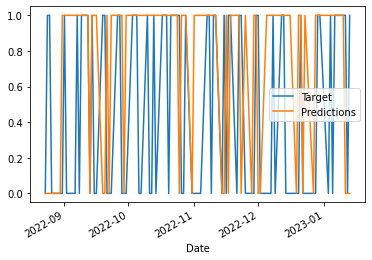

In [ ]:
combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)
combined.plot()

#Creating a backtesting function
Finally, we’ll wrap the loop in a function, to make it easier to work with. A function means we can easily call it later. The function will take the data, the machine learning model, and the predictors as inputs. We’ll also set start and step as optional parameters.

In the backtesting function, we will:
- Split the training and test data
- Train a model
- Make predictions on the test data using predict_proba
- Combine our predictions with the actual Target, so we can calculate error easily
- Return all of the predictions

This function will enable us to create predictions across our whole dataset whenever we want.

In [ ]:
def backtest(data, model, predictors, start=1000, step=750):
    predictions = []
    # Loop over the dataset in increments
    for i in range(start, data.shape[0], step):
        # Split into train and test sets
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()

        # Fit the random forest model
        model.fit(train[predictors], train["Target"])

        # Make predictions
        preds = model.predict_proba(test[predictors])[:,1]
        preds = pd.Series(preds, index=test.index)
        preds[preds >.65] = 1
        preds[preds<=.65] = 0

        # Combine predictions and test values
        combined = pd.concat({"Target": test["Target"],"Predictions": preds}, axis=1)

        predictions.append(combined)

    return pd.concat(predictions)

#Running the function
Now that we’ve created a backtesting function, we can call it to generate predictions across the entire dataset.

In [ ]:
predictions = backtest(data, model, predictors)

Next, let’s use the value_counts method to identify how many times the algorithm predicted the price would go up versus down.

As you can see, the algorithm only predicted that the price would go up 739 times. In the Target, you see that the price actually went up 3945 times. So the algorithm predicted the price would go up far fewer times than it actually did. This means that the algorithm had low recall, which is the % chance of finding all of the days where the price went up.

This is because we used .6 as a threshold for whether the price would go up or not. If we used a lower threshold, we would increase recall, but lower precision. Since we want to minimize our risk, we want to maximize precision. So it’s okay if the algorithm only predicts the price will go up on very few days.

In [ ]:
predictions["Predictions"].value_counts()

0.0    9601
1.0      10
Name: Predictions, dtype: int64

In [ ]:
predictions["Target"].value_counts()

1.0    4817
0.0    4794
Name: Target, dtype: int64

Finally, let’s look at precision. We can use the same function from before to evaluate this.

It looks like we have a low precision as well. This is because the algorithm has limited predictors to help it determine if the price will go up or down. We’ll add some more predictors next to help the algorithm make better decisions.

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

0.7

#Improving accuracy
The model isn’t very accurate, but at least now we can make predictions across the entire history of the stock. For this model to be useful, we have to get it to predict more accurately.

Let’s add some more predictors to see if we can improve accuracy.

We’ll add in some rolling means, so the model can evaluate the current price against recent prices. We’ll also look at the ratios between different indicators.

#Rolling means
Rolling means are useful because they can help the algorithm evaluate the current price against the average price this week, quarter, or year. For example, if the price now is higher than the annual price, it could mean that the stock is on an upward trend.

To calculate the rolling averages, we’ll again use the pandas rolling method to find the rolling mean of the Close column for different time horizons.

In [ ]:
weekly_mean = data.rolling(7).mean()["Close"]
quarterly_mean = data.rolling(90).mean()["Close"]
annual_mean = data.rolling(365).mean()["Close"]

weekly_trend = data.shift(1).rolling(7).sum()["Target"]

Next, we’ll add our weekly trend into the predictor DataFrame.

In [ ]:
data["weekly_mean"] = weekly_mean / data["Close"]
data["quarterly_mean"] = quarterly_mean / data["Close"]
data["annual_mean"] = annual_mean / data["Close"]

data["annual_weekly_mean"] = data["annual_mean"] / data["weekly_mean"]
data["annual_quarterly_mean"] = data["annual_mean"] / data["quarterly_mean"]

data["weekly_trend"] = weekly_trend

data["open_close_ratio"] = data["Open"] / data["Close"]
data["high_close_ratio"] = data["High"] / data["Close"]
data["low_close_ratio"] = data["Low"] / data["Close"]

In [ ]:
full_predictors = predictors + ["weekly_mean", "quarterly_mean", "annual_mean", "annual_weekly_mean", "annual_quarterly_mean", 
                                "open_close_ratio", "high_close_ratio", "low_close_ratio", "weekly_trend"]
predictions = backtest(data.iloc[365:], model, full_predictors)

In [ ]:
precision_score(predictions["Target"], predictions["Predictions"])

/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


0.0

In [ ]:
# Show how many trades we would make

predictions["Predictions"].value_counts()

0.0    7650
1.0    1596
Name: Predictions, dtype: int64

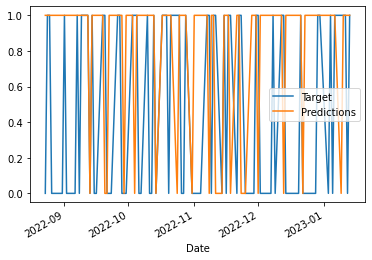

In [ ]:
# Look at trades we would have made in the last 100 days
predictions.iloc[-100:].plot()

#Next steps
We've come far in this project! We've downloaded and cleaned data, and setup a backtesting engine. We now have an algorithm that we can add more predictors to and continue to improve the accuracy of.

There are a lot of next steps we could take to improve our predictions:

#Improve the technique
- Calculate how much money you'd make if you traded with this algorithm

#Improve the algorithm
- Run with a reduced step size! This will take longer, but increase accuracy
- Try discarding older data (only keeping data in a certain window)
- Try a different machine learning algorithm
- Tweak random forest parameters, or the prediction threshold

#Add in more predictors
- Account for activity post-close and pre-open
  - Early trading
  - Trading on other exchanges that open before the NYSE (to see what the global sentiment is)
- Economic indicators
  - Interest rates
  - Other important economic news
- Key dates
  - Dividends
  - External factors like elections
- Company milestones
  - Earnings calls
  - Analyst ratings
  - Major announcements
- Prices of related stocks
  - Other companies in the same sector
  - Key partners, customers, etc.